### Question 1:
#### For the MNIST dataset, apply the feature reduction using singular value decomposition (SVD)

### Data Import


In [133]:
from keras.datasets import mnist

### Test train Split


In [134]:
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange,tqdm
%matplotlib inline

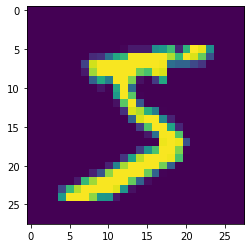

In [136]:
img1=plt.imshow(x_train1[0])
img1

In [137]:
x_train1[0].max()

255

### Normalizing the data

In [138]:
x_train1=x_train1/255
x_test1=x_test1/255

In [139]:
x_train1[0].max()

1.0

### Applying SVD to the images and reconstructing based on Number of Non Zero singular values of that corresponding images - Economic SVD

In [140]:
rank = np.zeros((x_train1.shape[0],1))
for i in range(x_train1.shape[0]):
    u,s,v = np.linalg.svd(x_train1[i])
    s1 = np.diag(s)
    svalue = np.linalg.matrix_rank(s1)  #Number of Non Zero Singular value is obtained from rank of Singular matrix 
    rank[i] = svalue
    s1 = s1[:svalue,:svalue]   
    u1 = u[:,:svalue]
    v1 = v[:svalue,:]
    reduced_img=u1@s1@v1
    x_train1[i]=reduced_img

In [141]:
np.unique(rank) # Expected Optimum feature is 18 or 19 or 20

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20.])

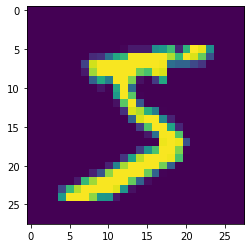

In [142]:
plt.imshow(x_train1[0])

### Applying SVD to the images and reconstructing based on first 18 singular values

In [46]:
svalue = 18  # Not using the Economic version, instead going for particular singular values for all images
for i in range(x_train1.shape[0]):
    u,s,v = np.linalg.svd(x_train1[i])
    s1 = np.diag(s)
    s1 = s1[:svalue,:svalue]
    u1 = u[:,:svalue]
    v1 = v[:svalue,:]
    reduced_img=u1@s1@v1
    x_train1[i]=reduced_img # Applied SVD for each image and reconstructed based to upto 18 singular values

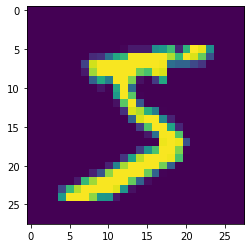

In [47]:
plt.imshow(x_train1[0])

# ---------------------------------------------------------------------------------------

### Question 2:
#### Classify the dataset using logistic regression before applying the feature reduction.
# ------------------------------------------------------------------------------------

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train/255
x_test=x_test/255

### Converting all image as a row vectors 

In [50]:
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

In [51]:
x_train.shape, y_train.shape

((60000, 784), (60000, 1))

### Bias column added to the data

In [52]:
padding = np.ones((60000,1)) #training padding
padding1 = np.ones((10000,1)) #test padding
x_train = np.concatenate((padding,x_train),axis=1)
x_test = np.concatenate((padding1,x_test),axis=1)

In [53]:
x_train.shape, x_test.shape

((60000, 785), (10000, 785))

### It is a Multi Class Classification dataset. Creating target vector based on one vs all concept 

In [54]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
# Training data target conversion
y_all = np.zeros([x_train.shape[0], len(np.unique(y_train))])
y_all = pd.DataFrame(y_all)
for i in range(0, len(np.unique(y_train))):
    y_all.iloc[:,i] = np.where(y_train==i,1,0)

In [56]:
# Testing data target conversion
y_test_all = np.zeros([x_test.shape[0], len(np.unique(y_test))])
y_test_all = pd.DataFrame(y_test_all)
for i in range(0, len(np.unique(y_test))):
    y_test_all.iloc[:,i] = np.where(y_test==i,1,0)

### Converting data into pandas dataframe for easy processing


In [57]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

### Model Creation for Weights update

In [129]:
def Weights_update(X, y, weights, alpha, iterations):
    m = len(X)
    for i in trange(0,iterations):
        for j in range(0, 10):
            weights = pd.DataFrame(weights)
            prediction = 1 / (1 + np.exp(-(np.dot(weights.iloc[:,j], X.T))))  #Sigmoid Function
            for n in range(0, weights.shape[0]):
                weights.iloc[n, j] -= (alpha/m) * np.sum((prediction-y.iloc[:, j])*X.iloc[:, n]) #1x1 B0 updation of class zero
                #785x1 when come out of individual weights for loop
            #785x10 when come out of class for loop                
            weights = pd.DataFrame(weights)
    return weights

In [59]:
weights = np.zeros([785, 10])                              # Initially weights are assumed to be zero
weights = Weights_update(x_train, y_all, weights, 0.3,100) # Updated Weights after 100 iterations with 0.3 Learning Rate

### Testing the model on test data

In [98]:
def prediction(weights,x_test):
    All_prediction = []
    for i in range(0, 10):
        weights1 = pd.DataFrame(weights)
        prediction = 1 / (1 + np.exp(-(np.dot(weights1.iloc[:,i], x_test.T))))
        All_prediction.append(prediction)
    All_prediction=pd.DataFrame(All_prediction)
    return All_prediction

In [99]:
def accuracy(y_test_all,All_prediction,x_test):
    accuracy = 0
    for col in range(0, 10):
        for row in range(len(y_test_all)):
            if y_test_all.iloc[row, col] == 1 and All_prediction.iloc[col, row] >= 0.5:
                accuracy += 1
    accuracy = accuracy/len(x_test)
    return accuracy

In [62]:
accuracy(y_test_all,prediction(weights,x_test),x_test)

0.7576

#### Accuracy of 0.7576 obtained at learning rate 0.3 and 100 iteration
#### Accuracy depends on two hyper parameters: Learning Rate and Number of Iteration
#### Less the Learning Rate and More the Number of Iterations will give more accuracy
# ----------------------------------------------------------------------------------------

### Question 3:
#### Classify the dataset using logistic regression after applying the feature reduction using SVD.
# --------------------------------------------------------------------------------------

#### From Question 1, the feature reduced data with respect to singular value 18 is taken for Multi Class Logistic Regression

### Data Preprocessing

In [63]:
# Converting all image as a row vectors -----------------------------------------
x_train1 = x_train1.reshape(x_train1.shape[0],-1)
x_test1 = x_test1.reshape(x_test1.shape[0],-1)
y_train1 = y_train1.reshape(y_train1.shape[0],1)
y_test1 = y_test1.reshape(y_test1.shape[0],1)
#--------------------------------------------------------------------------------
# Bias column added to the data--------------------------------------------------
padding = np.ones((60000,1)) #training padding
padding1 = np.ones((10000,1)) #test padding
x_train1 = np.concatenate((padding,x_train1),axis=1)
x_test1 = np.concatenate((padding1,x_test1),axis=1)
#--------------------------------------------------------------------------------
# It is a Multi Class Classification dataset. Creating target vector based on one vs all concept 
# Training data target conversion------------------------------------------------
y_all1 = np.zeros([x_train1.shape[0], len(np.unique(y_train1))])
y_all1 = pd.DataFrame(y_all1)
for i in range(0, len(np.unique(y_train1))):
    y_all1.iloc[:,i] = np.where(y_train1==i,1,0)
# Testing data target conversion-------------------------------------------------
y_test_all1 = np.zeros([x_test1.shape[0], len(np.unique(y_test1))])
y_test_all1 = pd.DataFrame(y_test_all1)
for i in range(0, len(np.unique(y_test1))):
    y_test_all1.iloc[:,i] = np.where(y_test1==i,1,0)
#--------------------------------------------------------------------------------
# Converting data into pandas dataframe for easy processing----------------------
x_train1 = pd.DataFrame(x_train1)
x_test1 = pd.DataFrame(x_test1)
#--------------------------------------------------------------------------------

In [64]:
weights1 = np.zeros([785, 10])                              # Initially weights are assumed to be zero
weights1 = Weights_update(x_train1, y_all1, weights1, 0.3,100) # Updated Weights after 100 iterations

In [65]:
accuracy(y_test_all1,prediction(weights1,x_test1),x_test1)

0.7576

#### Accuracy of 0.7576 obtained after applying SVD (Feature reduction), learning rate 0.3 and 100 iteration
#### Accuracy depends on three hyper parameters: Number of Singular Value, Learning Rate and Number of Iteration
#### Optimum Singular Value, Less the Learning Rate and More the Number of Iterations will give more accuracy
# ----------------------------------------------------------------------------------------

### Question 4:
#### Find the optimal feature dimension based on the accuracy
# ---------------------------------------------------------------------------------------

#### Plotting Singular value vs Accuracy - Using Inbuilt functions. 
##### As inbuit is choosen over the scratch because, there are hyper parameters which needs to be optimized in case of scratch. And identifying these optimal hyper parameters and running the model for that will be expensive in terms of computation time. By considering these two points, I have used the Inbuilt function to find optimum singular value using accuracy.

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
# Data Import and Normalization-------------------------------------------------
(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()
x_train2 = x_train2/255
x_test2 = x_test2/255
#--------------------------------------------------------------------------------
# Applying SVD and calculating Accuracy corresponding to the Singular Values-----
temp=[]
all_accuracy=[]
for j in trange(6,29):     # Iteration for Selected Singular Values
    for i in range(x_train2.shape[0]):  # Iteration for Number of Training Image
        x_train=x_train2
        u,s,v = np.linalg.svd(x_train[i])
        s2 = np.diag(s)
        s2 = s2[:j,:j]
        u2 = u[:,:j]
        v2 = v[:j,:]
        reduced_img=u2@s2@v2
        x_train[i]=reduced_img#----------# Feature Reduced Training Data
    x_train = x_train.reshape(x_train.shape[0],-1)
    x_test2 = x_test2.reshape(x_test2.shape[0],-1)
    #y_train2 = y_train2.reshape(y_train2.shape[0],1)
    #y_test2 = y_test2.reshape(y_test2.shape[0],1)
    #--------------------------------------------------------------------------------
    logmodel = LogisticRegression()
    logmodel.fit(x_train,y_train2)
    prediction = logmodel.predict(x_test2)
    temp = accuracy_score(y_test2,prediction)
    all_accuracy.append(temp)

  0%|          | 0/23 [00:00<?, ?it/s]

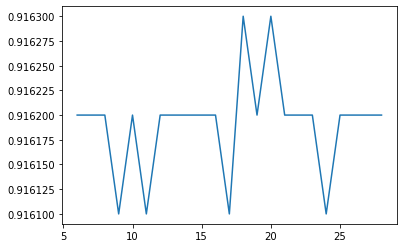

In [172]:
svalues=np.arange(6,29)
plt.plot(svalues,all_accuracy)

#### At Singular Value 18 and 20 - 0.9163 accuracy observed. Hence the optimum number of feature required is 18.
# ---------------------------------------------------------------------------------------

### Question 5:
#### For the optimal feature dimension, evaluate the model before and after applying the feature dimension based on Precision, Recall and F1-Score for each class
# ----------------------------------------------------------------------------------------

#### From Question 4 -> optimum feature dimension is 18. Calculating Precision, Recall and F1 Score for each class corresponding to that feature dimension

In [91]:
# Data Import and Normalization-------------------------------------------------
(x_train3, y_train3), (x_test3, y_test3) = mnist.load_data()
x_train3 = x_train3/255
x_test3 = x_test3/255
Predictions = []
#Predictions = np.zeros([10,785])
for i in range(x_train3.shape[0]):  # Iteration for Number of Training Image
    x_train=x_train3
    x_test=x_test3
    y_train=y_train3
    y_test=y_test3
    u,s,v = np.linalg.svd(x_train[i])
    s2 = np.diag(s)
    s2 = s2[:19,:19]
    u2 = u[:,:19]
    v2 = v[:19,:]
    reduced_img=u2@s2@v2
    x_train[i]=reduced_img#----------# Feature Reduced Training Data
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
#--------------------------------------------------------------------------------
# Bias column added to the data--------------------------------------------------
padding = np.ones((60000,1)) #training padding
padding1 = np.ones((10000,1)) #test padding
x_train = np.concatenate((padding,x_train),axis=1)
x_test = np.concatenate((padding1,x_test),axis=1)
#--------------------------------------------------------------------------------
# It is a Multi Class Classification dataset. Creating target vector based on one vs all concept 
# Training data target conversion------------------------------------------------
y_all = np.zeros([x_train.shape[0], len(np.unique(y_train))])
y_all = pd.DataFrame(y_all)
for i in range(0, len(np.unique(y_train))):
    y_all.iloc[:,i] = np.where(y_train==i,1,0)
# Testing data target conversion-------------------------------------------------
y_test_all = np.zeros([x_test.shape[0], len(np.unique(y_test))])
y_test_all = pd.DataFrame(y_test_all)
for i in range(0, len(np.unique(y_test))):
    y_test_all.iloc[:,i] = np.where(y_test==i,1,0)
#--------------------------------------------------------------------------------
# Converting data into pandas dataframe for easy processing----------------------
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
#--------------------------------------------------------------------------------
weights = np.zeros([785, 10])                              # Initially weights are assumed to be zero
weights = Weights_update(x_train, y_all, weights, 0.3,100) # Updated Weights after 100 iterations
Predictions = prediction(weights,x_test)

### Precision, Recall and F1 Score for optimum feature dimension

In [101]:
Predictions1 = (np.where(Predictions<0.5,0,1)).T
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(Predictions1,y_test_all))
accuracy(y_test_all,prediction(weights,x_test),x_test)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       956
           1       0.93      0.97      0.95      1090
           2       0.74      0.95      0.84       807
           3       0.75      0.91      0.82       825
           4       0.77      0.94      0.84       801
           5       0.58      0.91      0.71       569
           6       0.86      0.92      0.89       889
           7       0.83      0.96      0.89       887
           8       0.52      0.80      0.63       634
           9       0.63      0.85      0.73       750

   micro avg       0.76      0.92      0.83      8208
   macro avg       0.75      0.92      0.82      8208
weighted avg       0.78      0.92      0.84      8208
 samples avg       0.76      0.74      0.75      8208



0.7576

### Before applying feature reduction

In [102]:
# Data Import and Normalization-------------------------------------------------
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1/255
x_test1 = x_test1/255
# Converting all image as a row vectors -----------------------------------------
x_train1 = x_train1.reshape(x_train1.shape[0],-1)
x_test1 = x_test1.reshape(x_test1.shape[0],-1)
y_train1 = y_train1.reshape(y_train1.shape[0],1)
y_test1 = y_test1.reshape(y_test1.shape[0],1)
#--------------------------------------------------------------------------------
# Bias column added to the data--------------------------------------------------
padding = np.ones((60000,1)) #training padding
padding1 = np.ones((10000,1)) #test padding
x_train1 = np.concatenate((padding,x_train1),axis=1)
x_test1 = np.concatenate((padding1,x_test1),axis=1)
#--------------------------------------------------------------------------------
# It is a Multi Class Classification dataset. Creating target vector based on one vs all concept 
# Training data target conversion------------------------------------------------
y_all1 = np.zeros([x_train1.shape[0], len(np.unique(y_train1))])
y_all1 = pd.DataFrame(y_all1)
for i in range(0, len(np.unique(y_train1))):
    y_all1.iloc[:,i] = np.where(y_train1==i,1,0)
# Testing data target conversion-------------------------------------------------
y_test_all1 = np.zeros([x_test1.shape[0], len(np.unique(y_test1))])
y_test_all1 = pd.DataFrame(y_test_all1)
for i in range(0, len(np.unique(y_test1))):
    y_test_all1.iloc[:,i] = np.where(y_test1==i,1,0)
#--------------------------------------------------------------------------------
# Converting data into pandas dataframe for easy processing----------------------
x_train1 = pd.DataFrame(x_train1)
x_test1 = pd.DataFrame(x_test1)
#--------------------------------------------------------------------------------
weights1 = np.zeros([785, 10])                              # Initially weights are assumed to be zero
weights1 = Weights_update(x_train1, y_all1, weights1, 0.3,100) # Updated Weights after 100 iterations
Predictions = prediction(weights1,x_test1)

In [112]:
Predictions2 = (np.where(Predictions<0.5,0,1)).T
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(Predictions2,y_test_all1))
accuracy(y_test_all1,prediction(weights1,x_test1),x_test1)

C:\Users\ARUL GOUTHAM RAJU\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       956
           1       0.93      0.97      0.95      1090
           2       0.74      0.95      0.84       807
           3       0.75      0.91      0.82       825
           4       0.77      0.94      0.84       801
           5       0.58      0.91      0.71       569
           6       0.86      0.92      0.89       889
           7       0.83      0.96      0.89       887
           8       0.52      0.80      0.63       634
           9       0.63      0.85      0.73       750

   micro avg       0.76      0.92      0.83      8208
   macro avg       0.75      0.92      0.82      8208
weighted avg       0.78      0.92      0.84      8208
 samples avg       0.76      0.74      0.75      8208



0.7576

#### Two major points were observed based on the results obtained from before and after applying feature reduction:
#### 1. Precision, Recall and F1-Score are Same for both the case
#### 2. Processing time After feature reduction is less when compared with before feature reduction
#### Hence the optimum number of features replaces data with all features 